# DSI19 Project 4 - Model Selection and Evaluation
---

## Table of Contents

* [1. Modeling Strategy](#chapter1)
* [2. Data Preparation](#chapter2)
    * [2.1 Dealing with Categorical Variables](#chapter2_1)
    * [2.2 Split into Train/Validation/Test Data](#chapter2_2)
    * [2.3 Scaling the Data](#chapter2_3)
* [3. Establishing Baseline](#chapter3)
* [4. Fit and Evaluate Models](#chapter4)
    * [4.1 Cross Validation Scores](#chapter4_1)
    * [4.2 Tuning Hyperparameters](#chapter4_2)
    * [4.3 Refit Model and Evaluate Test Data](#chapter4_3)
* [5. Kaggle Submissions](#chapter5)
* [6. Cost Benefit Analysis](#chapter6)
    * [6.1 Assumptions](#chapter6_1)
    * [6.2 Spray Costs](#chapter6_2)
    * [6.3 Economic Loss of Activity](#chapter6_3)
    * [6.4 Medical Costs](#chapter6_4)
    * [6.5 Cost Benefit Analysis](#chapter6_5)
    * [6.6 Conclusion](#chapter6_6)
* [7. Key Takeaways and Recommendations](#chapter7)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

In [2]:
train = pd.read_csv('../data/model_train.csv')
kaggle_test = pd.read_csv('../data/model_test.csv')

## 1. Modeling Strategy <a class="anchor" id="chapter1"></a>
---
The model aims to predict WNV positivity with `1` indicating presence of WNV and `0` indicating no presence of WNV. This makes it a classification problem. Classification models to be tested are:

- Logistic Regression
- K Nearest Neighbors
- Decision Trees
- Bagged Decision Trees
- Random Forest
- Adaboost Classifier
- Support Vector Classifier

Before running the data on the models, the train data set will be split into training/testing/validation for evaluation purposes.

## 2. Data Preparation <a class="anchor" id="chapter2"></a>
---


In [3]:
display(train.head())

,Species,Latitude,Longitude,Tavg,PrecipTotal,DewPoint,R_Humid,day,month,year,loc_weight,WnvPresent
0,CULEX PIPIENS/RESTUANS,41.867108,-87.654224,68.714286,0.108571,50.928571,53.064667,29,5,2007,0.0,0
1,CULEX RESTUANS,41.867108,-87.654224,68.714286,0.108571,50.928571,53.064667,29,5,2007,0.0,0
2,CULEX RESTUANS,41.862292,-87.648860,68.714286,0.108571,50.928571,53.064667,29,5,2007,0.0,0
3,CULEX RESTUANS,41.896282,-87.655232,68.714286,0.108571,50.928571,53.064667,29,5,2007,0.0,0
4,CULEX RESTUANS,41.907645,-87.760886,68.714286,0.108571,50.928571,53.064667,29,5,2007,0.0,0


### 2.1 Dealing with Categorical Variables <a class="anchor" id="chapter2_1"></a>

In [4]:
# Get dummies on train and kaggle test data set
train = train.join(pd.get_dummies(train['Species'],drop_first=True))
train.drop('Species',axis='columns',inplace=True)

kaggle_test = kaggle_test.join(pd.get_dummies(kaggle_test['Species'],drop_first=True))
kaggle_test.drop('Species',axis='columns',inplace=True)

In [5]:
# Check columns and shape to ensure they are they same columns
print(train.columns)
print(train.shape)
print(kaggle_test.columns)
print(kaggle_test.shape)

Index(['Latitude', 'Longitude', 'Tavg', 'PrecipTotal', 'DewPoint', 'R_Humid',
       'day', 'month', 'year', 'loc_weight', 'WnvPresent', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS'],
      dtype='object')
(8475, 17)
Index(['Id', 'Latitude', 'Longitude', 'Tavg', 'PrecipTotal', 'DewPoint',
       'R_Humid', 'day', 'month', 'year', 'loc_weight', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS', 'UNSPECIFIED CULEX'],
      dtype='object')
(116293, 18)


In [6]:
# Drop additional species data from test set to ensure same columns with train data
kaggle_test.drop('UNSPECIFIED CULEX', axis='columns', inplace=True)

### 2.2 Split into Train/Validation/Test Data <a class="anchor" id="chapter2_2"></a>

In [7]:
# Specify X and y variables
X = train[[col for col in train.columns if col not in ['WnvPresent']]]
y = train['WnvPresent']

In [8]:
# Train test split to split into sample and test data sets
X_sample, X_test, y_sample, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=42)

# Train test split to split sample into train and validation data sets
X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, shuffle=True, stratify=y_sample, random_state=42)

### 2.3 Scaling the Data <a class="anchor" id="chapter2_3"></a>

In [9]:
# Instantiate scalar
ss = StandardScaler()

# Fit and transform X_train
X_train_ss = ss.fit_transform(X_train)
# Transform X_val
X_val_ss = ss.transform(X_val)

## 3. Establishing Baseline <a class="anchor" id="chapter3"></a>
---
For the baseline, we will be using a vanilla Logistic Regression model. This baseline score will be used as a benchmark against other models for evaluation purposes.

In [10]:
# Instantiate vanilla logistic regression model
lr = LogisticRegression()
# Fit the model
lr.fit(X_train_ss, y_train)

# Getting the cross val score, prediction on train and test sets, and ROC AUC scores for train and test sets
cvs = cross_val_score(lr, X_train_ss, y_train, cv=5, scoring='roc_auc').mean()
preds_train = lr.predict_proba(X_train_ss)[:,1]
preds_val = lr.predict_proba(X_val_ss)[:,1]
roc_train = roc_auc_score(y_train, preds_train)
roc_val = roc_auc_score(y_val, preds_val)

print(f"Cross validation score: {cvs}.")
print(f"ROC AUC score on train set: {roc_train}.")
print(f"ROC AUC score on test set: {roc_val}.")

Cross validation score: 0.8154502479825293.
ROC AUC score on train set: 0.8227673910980354.
ROC AUC score on test set: 0.7703662442556747.


In [11]:
# Function for plotting ROC AUC curve
def plot_rocauc(true,preds):
    # Get false positive rate and true positive rate
    fpr, tpr, threshold = roc_curve(true, preds)

    plt.figure(figsize=(12,8))

    plt.plot(fpr, # False Positive Rate on X-axis
             tpr, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title(f"ROC Curve with AUC = {round(roc_auc_score(true,preds),5)}", fontsize=15)
    plt.ylabel('Sensitivity', fontsize=12)
    plt.xlabel('1 - Specificity', fontsize=12)

    # Create legend.
    plt.legend(fontsize=12);

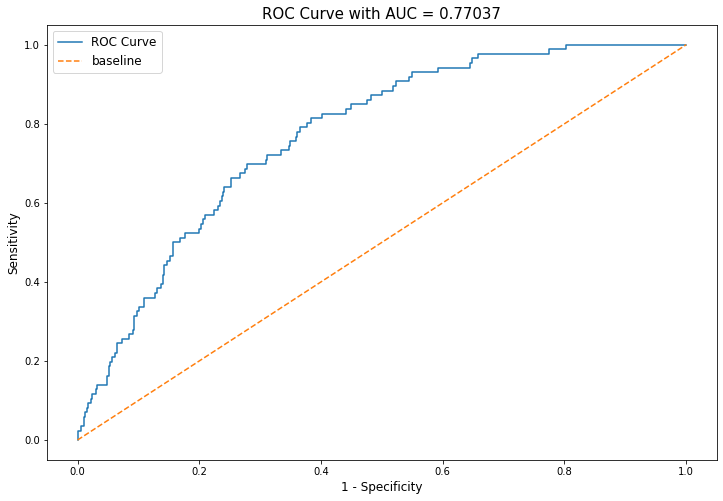

In [12]:
plot_rocauc(y_val, preds_val)

The ROC AUC score obtained by a vanilla logistic regression model is around 0.80. We will aim to develop models to achieve ROC AUC of > 0.80.

## 4. Fit and Evaluate Models <a class="anchor" id="chapter4"></a>
---

Classification models that we will be evaluating are:
- Logistic Regression
- K Nearest Neighbors
- Decision Trees
- Bagged Decision Trees
- Random Forest
- Adaboost Classifier
- Support Vector Classifier


### 4.1 Cross Validation Scores <a class="anchor" id="chapter4_1"></a>

In [13]:
# Instantiating classification models
lr = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
bagging = BaggingClassifier()
rand_forest = RandomForestClassifier()
ada = AdaBoostClassifier()
svc = SVC(probability=True)

# Creating list of models
model_list = [lr, knn, dt, bagging, rand_forest, ada, svc]

In [14]:
# Defining function to fit and evaluate models
def model_eval(m_list):
    # Dictionary to store evaluation data
    eval_dict = {
        'model' : ['log_reg', 'knn', 'decision_tree', 'bagged_trees', 'rand_forest', 'ada', 'svc'], # model name
        'cvs' : [], # cross validation score
        'train_score' : [], # ROC AUC on train data
        'val_score' : [], # ROC AUC on validation data
        'tn' : [], # True negatives
        'fp' : [], # False positives
        'fn' : [], # False negatives
        'tp' : []} # True positives
        
    for model in model_list: # Iterate through all models
        model.fit(X_train_ss, y_train) # Fit the model
        # Obtain cross validation score
        cv_score = cross_val_score(model, X_train_ss, y_train, cv=5, scoring='roc_auc').mean()
        # Predict the probabilities on train and validation data
        preds_train = model.predict_proba(X_train_ss)[:,1]
        preds_val = model.predict_proba(X_val_ss)[:,1]
        # ROC AUC score for predictions
        roc_train = roc_auc_score(y_train, preds_train)
        roc_val = roc_auc_score(y_val, preds_val)
        # Confusion matric based on prediction on validation data
        tn, fp, fn, tp = confusion_matrix(y_val, model.predict(X_val_ss)).ravel()
        # Append values to evaluation dictionary
        eval_dict['cvs'].append(cv_score)
        eval_dict['train_score'].append(roc_train)
        eval_dict['val_score'].append(roc_val)
        eval_dict['tn'].append(tn)
        eval_dict['fp'].append(fp)
        eval_dict['fn'].append(fn)
        eval_dict['tp'].append(tp)

    model_results = pd.DataFrame(eval_dict)
    # Calculate sensitivity
    model_results['sensitivity'] = model_results['tp'] / (model_results['tp'] + model_results['fn'])
    # Calculate specificity
    model_results['specificity'] = model_results['tn'] / (model_results['tn'] + model_results['fp'])
    
    return model_results

display(model_eval(model_list))

,model,cvs,train_score,val_score,tn,fp,fn,tp,sensitivity,specificity
0,log_reg,0.815450,0.822767,0.770366,1503,0,86,0,0.000000,1.000000
1,knn,0.693379,0.952840,0.640924,1478,25,84,2,0.023256,0.983367
2,decision_tree,0.603301,1.000000,0.580699,1431,72,68,18,0.209302,0.952096
3,bagged_trees,0.767912,0.999707,0.756974,1472,31,70,16,0.186047,0.979375
4,rand_forest,0.841357,1.000000,0.833848,1477,26,80,6,0.069767,0.982701
5,ada,0.883760,0.911832,0.871316,1499,4,85,1,0.011628,0.997339
6,svc,0.772007,0.932791,0.730175,1503,0,86,0,0.000000,1.000000


Observations:
- 2 models, `Random Forest` and `Adaboost` had higher cross validation scores than our baseline `Logistic Regression` model
- `Decision Trees` and `Bagged Trees` seem to give lower number of false negatives. This is essential as false negatives means that the virus is actually present in the area but was predicted as not present. In order to best minimise the spread, we would need to minimise false negatives.

In conclusion, we will optimise parameters using GridSearch for the following models:
- Decision Trees
- Bagged Decision Trees
- Random Forest
- Adaboost Classifier

### 4.2 Tuning Hyperparameters <a class="anchor" id="chapter4_2"></a>

In [15]:
# Define function for gridsearch, taking in model and parameter grid
def grid_search(model_dict):
    
    gs_results = {
        'model':[],
        'opt_params':[],
        'train_score':[],
        'val_score':[],
        'best_model':[]
    }

    for model, params in model_dict.items():
        # Instantiate gridsearch using ROC AUC metric
        gs = GridSearchCV(estimator=model,
                         param_grid=params,
                         scoring='roc_auc',
                         cv=5,
                         verbose=1)
        gs.fit(X_train_ss, y_train) # fit the model
        best_params = gs.best_params_ # obtain best parameters
        train_score = gs.best_score_ # ROC AUC score on train data
        val_score = gs.score(X_val_ss, y_val) # ROC AUC score on validation data
        best_model = gs.best_estimator_

        # Storing data for evaluation
        gs_results['model'].append(model)
        gs_results['opt_params'].append(best_params)
        gs_results['train_score'].append(train_score)
        gs_results['val_score'].append(val_score)
        gs_results['best_model'].append(best_model)
    
        print(f"Best parameters for {model} is {best_params}.")
        print(f"Score on train set: {train_score}.")
        print(f"Score on validation set: {val_score}.")
    
    return pd.DataFrame(gs_results)

In [16]:
# Instantiating models
dt = DecisionTreeClassifier()
bag_trees = BaggingClassifier(n_jobs=-1)
rand_forest = RandomForestClassifier(n_jobs=-1)
ada = AdaBoostClassifier()

In [17]:
# Creating class weights based on labels in training data
wnv_class = dict(y_train.value_counts(normalize=True))

# Defining parameter grid for different models

dt_params = {'criterion':['gini','entropy'],
            'splitter':['best', 'random'],
            'max_depth': [3,5,15],
            'max_features': [5,10,16],
            'class_weight': [None, wnv_class]}

bag_params = {'n_estimators' : [400, 450, 500],
              'max_features' : [8, 12, 16]}

randf_params = {'n_estimators':[150, 250, 300],
               'max_depth':[3, 5, 10],
               'max_features':[7, 12, 16],
               'class_weight':[None, wnv_class]}

ada_params = {'n_estimators':[20, 50, 100],
             'learning_rate':[0.5, 1, 1.5]}


In [18]:
# Creating dictionary to store model with model params
model_dict = {
    dt : dt_params,
    bag_trees : bag_params,
    rand_forest : randf_params,
    ada : ada_params
}

In [19]:
gs_results = grid_search(model_dict) # Run function on dataframe and store results as gs_results
display(gs_results)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters for DecisionTreeClassifier() is {'class_weight': {0: 0.9460876861757919, 1: 0.053912313824208094}, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 16, 'splitter': 'best'}.
Score on train set: 0.8649396932574838.
Score on validation set: 0.8642559841557196.
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   33.3s finished


Best parameters for BaggingClassifier(n_jobs=-1) is {'max_features': 16, 'n_estimators': 400}.
Score on train set: 0.8668349703859031.
Score on validation set: 0.8457078091878258.
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.6min finished


Best parameters for RandomForestClassifier(n_jobs=-1) is {'class_weight': None, 'max_depth': 5, 'max_features': 16, 'n_estimators': 300}.
Score on train set: 0.8871444134535956.
Score on validation set: 0.8650992588466477.
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    7.5s finished


Best parameters for AdaBoostClassifier() is {'learning_rate': 1.5, 'n_estimators': 50}.
Score on train set: 0.8839820091434152.
Score on validation set: 0.8726771263674203.


,model,opt_params,train_score,val_score,best_model
0,DecisionTreeClassifier(),"{'class_weight': {0: 0.9460876861757919, 1: 0....",0.864940,0.864256,DecisionTreeClassifier(class_weight={0: 0.9460...
1,BaggingClassifier(n_jobs=-1),"{'max_features': 16, 'n_estimators': 400}",0.866835,0.845708,(DecisionTreeClassifier(random_state=151241858...
2,RandomForestClassifier(n_jobs=-1),"{'class_weight': None, 'max_depth': 5, 'max_fe...",0.887144,0.865099,"(DecisionTreeClassifier(max_depth=5, max_featu..."
3,AdaBoostClassifier(),"{'learning_rate': 1.5, 'n_estimators': 50}",0.883982,0.872677,"(DecisionTreeClassifier(max_depth=1, random_st..."


Observations:
- `Random Forests` score on train data decreased but increase on validation data. Tuning the hyperparameters helped to reducce overfitting, increasing the bias on the train score but achieving lesser variance
- `Adaboost` seems to perform very well as well, with reduced overfitting after hyperparameters were tuned.

### 4.3 Refit Model and Evaluate Test Data <a class="anchor" id="chapter4_3"></a>

After tuning the hyperparameters, we will used the optimal models to fit on the entire train and validation data (earlier defined as the X_sample), and test on the withheld test data set to evaluate how well each model generalises.

In [20]:
# Create list of models with optimal parameters
opt_model_list = gs_results['best_model']

# Refit standard scalary on entire train and validation data
ss = StandardScaler()
X_sample_ss = ss.fit_transform(X_sample)
# Transform test data set with fitted standard scalar
X_test_ss = ss.transform(X_test)

In [21]:
# Function to get ROC AUC score, confusion matrix, sensitivity and specificity scores
def pred_results(model_list):
    # Dictionary to store results
    gen_results = {
        'model':[], # Model used
        'train_roc':[], # ROC AUC on X_sample
        'test_roc':[], # ROC AUC on X_test
        'tn': [], # True negatives
        'fp': [], # False positives
        'fn': [], # False negatives
        'tp': [], # True positives
    } 
    
    for model in model_list: # Iterate through all the models
        # Fit the model
        model.fit(X_sample_ss, y_sample)
        # Get prediction probabilities
        train_preds = model.predict_proba(X_sample_ss)[:,1]
        test_preds = model.predict_proba(X_test_ss)[:,1]
        # Store ROC AUC scores
        train_roc = roc_auc_score(y_sample, train_preds)
        test_roc = roc_auc_score(y_test, test_preds)
        # Confusion matrix values
        tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test_ss)).ravel()
        # Appending information to dictionary for each model
        gen_results['model'].append(model)
        gen_results['train_roc'].append(train_roc)
        gen_results['test_roc'].append(test_roc)
        gen_results['tn'].append(tn)
        gen_results['fp'].append(fp)
        gen_results['fn'].append(fn)
        gen_results['tp'].append(tp)
    # Generate a dataframe of the results
    gen_results = pd.DataFrame(gen_results)
    # Calculate sensitivity
    gen_results['sensitivity'] = gen_results['tp'] / (gen_results['tp'] + gen_results['fn'])
    # Calculate specificity
    gen_results['specificity'] = gen_results['tn'] / (gen_results['tn'] + gen_results['fp'])
    
    return gen_results

In [22]:
gen_results = pred_results(opt_model_list)
display(gen_results)

,model,train_roc,test_roc,tn,fp,fn,tp,sensitivity,specificity
0,DecisionTreeClassifier(class_weight={0: 0.9460...,0.895924,0.876066,2004,1,114,0,0.000000,0.999501
1,(DecisionTreeClassifier(random_state=790239968...,1.000000,0.866037,1969,36,93,21,0.184211,0.982045
2,"(DecisionTreeClassifier(max_depth=5, max_featu...",0.923658,0.903063,2004,1,113,1,0.008772,0.999501
3,"(DecisionTreeClassifier(max_depth=1, random_st...",0.903558,0.888841,2005,0,113,1,0.008772,1.000000


Evaluation:
- Based on ROC AUC scores, it seems that `random forest` performs the best due to good ROC AUC scores on both the train and test set, and minimal differences between the two, indicating that the model has low bias and low variance.
- However, based on the confusion matrix, `bagged trees` best fulfils the problem statement as it achieved the highest true positives (predicted WNV virus and has WNV virus), as well as minimal false negatives (predicted no WNV but has WNV). 
- False negatives are particularly problematic for our problem statement as it means that they model did not predict those locations as positive, and therefore no action was taken. These locations actually had the WNV virus but no action was taken to curb the virus, leading to increased chances of spreading the virus.

In [23]:
def plot_metrics(model):
    model.fit(X_sample_ss, y_sample)
    
    pred_prob_1 = model.predict_proba(X_test_ss)[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, pred_prob_1)

    fix, ax = plt.subplots(1,2, figsize=(16,8))
    plt.suptitle(f'Plots for {model}',fontsize=18)

    ax[0].hist(pred_prob_1, bins=25, color='orange')
    ax[0].set_title('Distribution of Probabilities for Prediction = 1', fontsize=15)
    ax[0].set_xlabel('Predicted Probabilities', fontsize=12)
    ax[0].set_ylabel('Frequency', fontsize=12)

    ax[1].plot(fpr, tpr, label='ROC Curve')
    ax[1].plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200), label='baseline', linestyle='--')
    ax[1].set_title(f"ROC Curve", fontsize=15)
    ax[1].set_ylabel('Sensitivity', fontsize=12)
    ax[1].set_xlabel('1 - Specificity', fontsize=12)
    
    plt.tight_layout()
    plt.show()

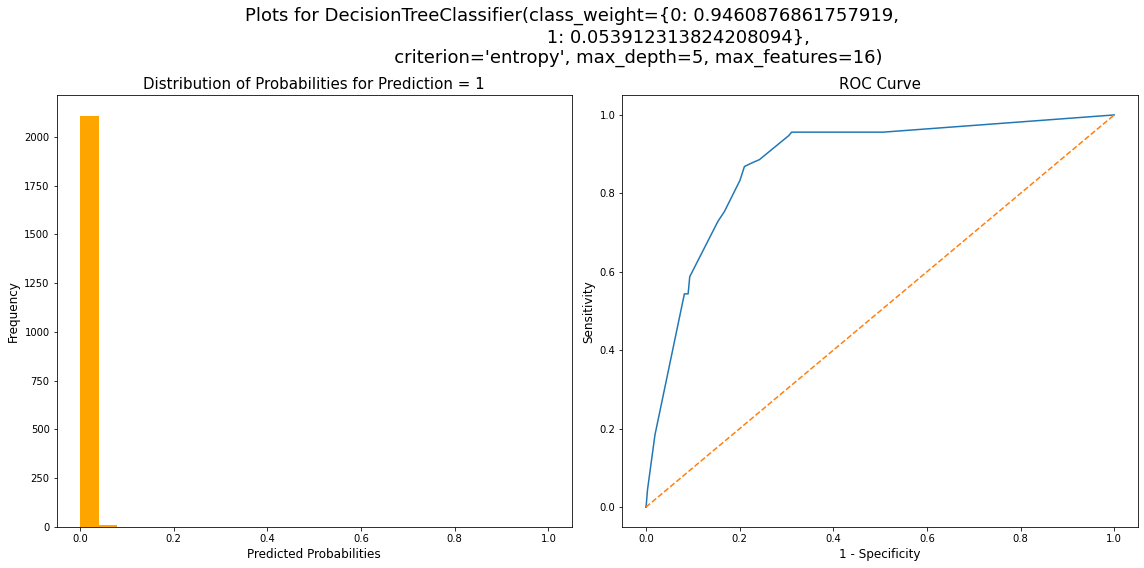

In [24]:
# Plot metrics for Decision Tree Classifier
plot_metrics(gen_results['model'][0])

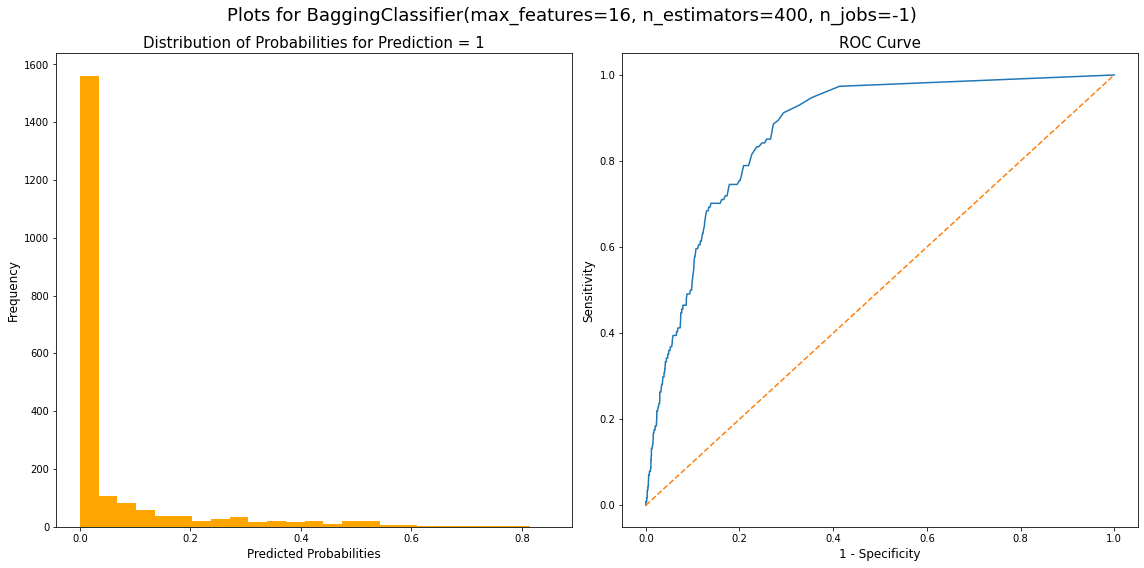

In [25]:
# Plot metrics for Bagged Trees Classifier
plot_metrics(gen_results['model'][1])

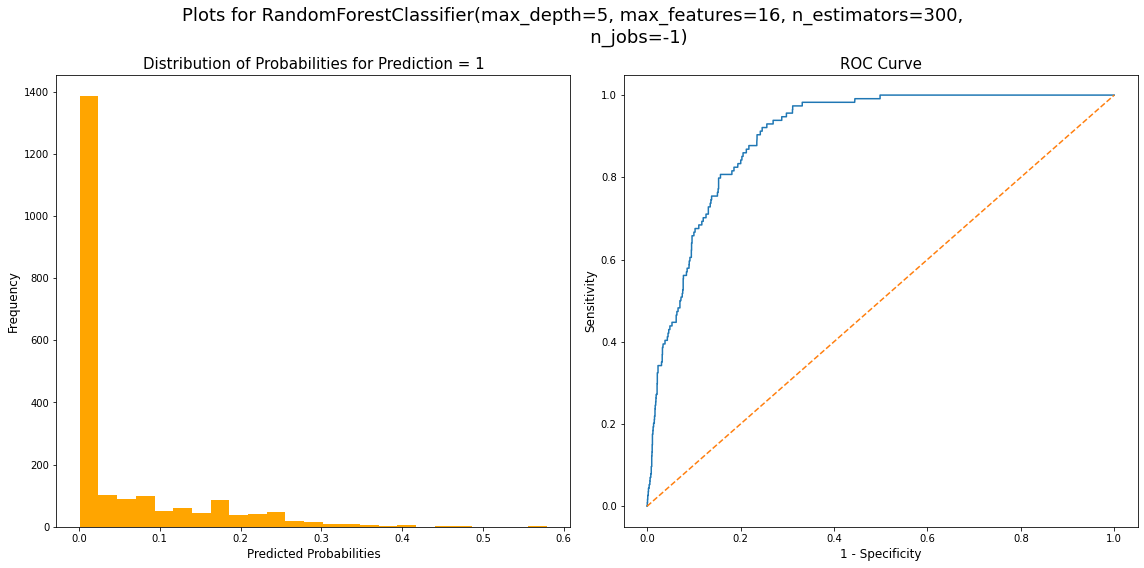

In [26]:
# Plot metrics for Random Forests Classifier
plot_metrics(gen_results['model'][2])

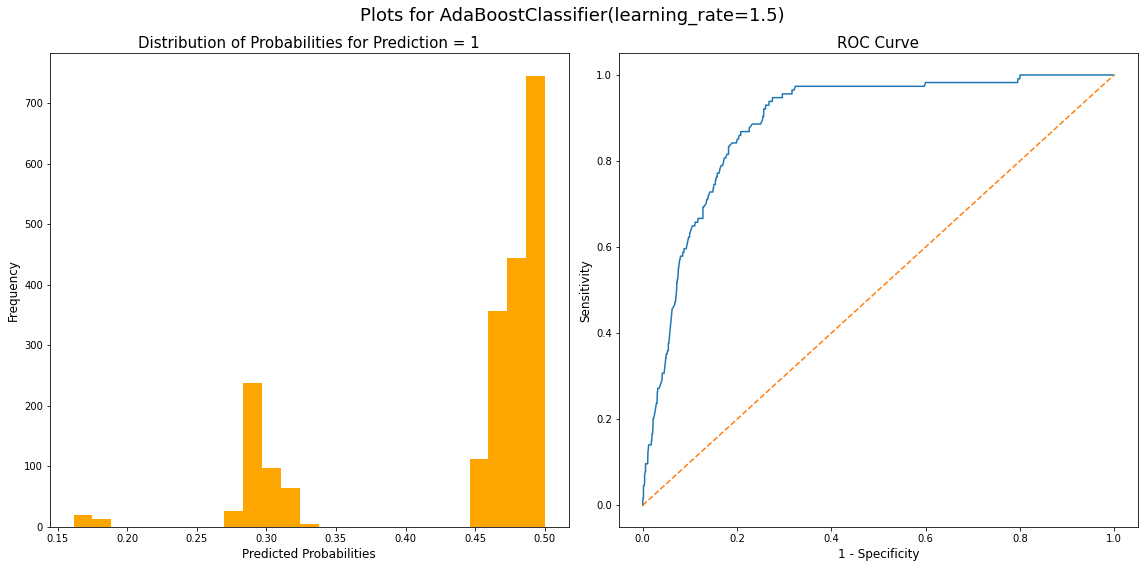

In [27]:
# Plot metrics for Adaboost Classifier
plot_metrics(gen_results['model'][3])

Observations:
- `Random Forests` and `Adaboost` seem to achieve the highest area under the curve for ROC AUC
- Distributions for `Decision Trees` is heavily skewed with most values being 0
- `Bagged Trees` seem to have higher sensitivity scores, which minimises false negatives

## 5. Kaggle Submissions <a class="anchor" id="chapter5"></a>
---

Now that we have narrowed down these models, we will prepare results based on these 4 models for submission to Kaggle.

In [28]:
# Consolidate Sample and Test data to refit models based on entire data
X_train = train[[col for col in train.columns if col not in ['WnvPresent']]]
y_train = train['WnvPresent']

# Drop Id column in kaggle data set to ensure same features as training data
X_test = kaggle_test.drop(['Id'],axis=1)

In [29]:
# Instantiate scalar and scale data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [30]:
# Refit optimal models to full training data and store probablities for the different models
kaggle_probs = []
for model in opt_model_list:
    model.fit(X_train_ss, y_train)
    kaggle_probs.append(model.predict_proba(X_test_ss)[:,1])
    

In [31]:
# Preparing kaggle submission file for Decision Trees
dt_final = pd.DataFrame([kaggle_test['Id'], kaggle_probs[0]]).T
dt_final.rename({'Unnamed 0':'WnvPresent'},axis='columns',inplace=True)
dt_final['Id'] = dt_final['Id'].astype('int32')
dt_final.to_csv('../kaggle_files/dec_tree.csv',index=False)

In [32]:
# Preparing kaggle submission file for Bagged Trees
bagged_final = pd.DataFrame([kaggle_test['Id'], kaggle_probs[1]]).T
bagged_final.rename({'Unnamed 0':'WnvPresent'},axis='columns',inplace=True)
bagged_final['Id'] = bagged_final['Id'].astype('int32')
bagged_final.to_csv('../kaggle_files/bagged.csv',index=False)

In [33]:
# Preparing kaggle submission file for Random Forests
rf_final = pd.DataFrame([kaggle_test['Id'], kaggle_probs[2]]).T
rf_final.rename({'Unnamed 0':'WnvPresent'},axis='columns',inplace=True)
rf_final['Id']= rf_final['Id'].astype('int32')
rf_final.to_csv('../kaggle_files/rf.csv',index=False)

In [34]:
# Preparing kaggle submission file for Adaboost Classifier
ada_final = pd.DataFrame([kaggle_test['Id'], kaggle_probs[3]]).T
ada_final.rename({'Unnamed 0':'WnvPresent'},axis='columns',inplace=True)
ada_final['Id'] = ada_final['Id'].astype('int32')
ada_final.to_csv('../kaggle_files/ada.csv',index=False)

<img src="../kaggle_files/kaggle_results.png" style="width: 500px;"/>

Observations:
- `Random Forest` performed the best with ROC AUC score of 0.72.
- `Bagged Forest` also seems to perform relatively well with 0.70.

## 6. Cost Benefit Analysis <a class="anchor" id="chapter6"></a>
---

`Random Forest` performs the best in terms of ROC AUC. However, `Bagged Trees` provides the highest sensitivity score, which minimises false negatives. A cost benefit analysis will be performed on these 2 models to decide which model provides better value.

In [35]:
display(gen_results)

,model,train_roc,test_roc,tn,fp,fn,tp,sensitivity,specificity
0,DecisionTreeClassifier(class_weight={0: 0.9460...,0.895924,0.876066,2004,1,114,0,0.000000,0.999501
1,(DecisionTreeClassifier(random_state=143564003...,1.000000,0.866037,1969,36,93,21,0.184211,0.982045
2,"(DecisionTreeClassifier(max_depth=5, max_featu...",0.923658,0.903063,2004,1,113,1,0.008772,0.999501
3,"(DecisionTreeClassifier(max_depth=1, random_st...",0.903558,0.888841,2005,0,113,1,0.008772,1.000000


### 6.1 Assumptions <a class="anchor" id="chapter6_1"></a>

Assumptions:
- Sprays will be conducted at all sites predicted as positive
- Sprays will be conducted for 7 consecutive days prior to positive event
- Cost comprises of - 
 - Cost of sprays (measurable)
 - Economic loss due to loss of work by infected individuals (measurable)
 - Medical fees for infected cases, assumed borne by state (measurable)
- Benefit comprises of - 
 - Prevention of economic loss of work for number of cases prevented (measurable)
 - Public health and confidence (cannot be measured)

### 6.2 Spray Costs <a class="anchor" id="chapter6_2"></a>

The Chicago Department of Public Health (CDPH) conducts control measures such as using trucks to dispense an ultra low volume spray of Zenivix [[source]](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes.html). The solution is sprayed at around 4.5 to 9 ounces per minute [[source]](https://www.cmmcp.org/pesticide-information/pages/zenivex-e4-etofenprox). The solution also roughly costs US$80/gallon [[source]](../assets/zenivex.pdf).

In [36]:
spraytime_per_day = 5 * 60 # 5 hours per day
gallon_per_minute = (4.5 + 9)/2 /128 # (Average spray rate) / (ounces/gallon)
cost_per_gallon = 80 # US$80 per gallon

cost_per_day = spraytime_per_day * gallon_per_minute * cost_per_gallon
cost_per_trap = cost_per_day * 7 
print(f"The spray cost per trap is US${round(cost_per_trap,2)}.")

The spray cost per trap is US$8859.38.


### 6.3 Economic Loss of Activity <a class="anchor" id="chapter6_3"></a>

Affected individuals will not be able to work during their recovery period. An estimation of this loss of economic activity will be used as a factor in the cost benefit analysis [[source]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/#R6).

<img src="../assets/economic_costs.png" style="width: 500px;"/>

In [37]:
econ_per_patient = 484800 / (31 + 15 + 12) # Total cost / number of patients
print(f"The average economic loss per patient is US${round(econ_per_patient,2)}.")

The average economic loss per patient is US$8358.62.


### 6.4 Medical Costs <a class="anchor" id="chapter6_4"></a>

In addition to loss of economic activity, medical expenses are also incurred by patients. Assuming that these medical costs are borne by the state, this also represents an additional factor of costs. For the purpose of this estimation, we will only look at costs that are applicable to all 46 patients.

<img src="../assets/medical_costs.png" style="width: 800px;"/>

In [38]:
med_per_patient = (1524570 + 20708 + 41810 + 2977) / 46
print(f"The average medical cost per patient is US${round(med_per_patient,2)}.")

The average medical cost per patient is US$34566.63.


### 6.5 Cost Benefit Analysis <a class="anchor" id="chapter6_5"></a>

In [39]:
print(train.groupby('year').sum()['WnvPresent']) # Get number of traps with positive virus presence in respective years

year
2007    189
2009     19
2011     50
2013    199
Name: WnvPresent, dtype: int64


<img src="../assets/cases_year.png" style="width: 800px;"/>

In [40]:
# Compute average cases per positive trap
print("Average cases per trap")
print(f"2007: {380/189}")
print(f"2009: {112/19}")
print(f"2011: {158/50}")
print(f"2013: {379/199}")
print(f"Total: {1029/457}")

Average cases per trap
2007: 2.0105820105820107
2009: 5.894736842105263
2011: 3.16
2013: 1.9045226130653266
Total: 2.25164113785558


For the purpose of analysis, we will assume 1 positive trap gives rise to 2.25 WNV infections.

In [41]:
def cba_analysis(fp, fn, tp):
    estimated_cases = round((fn + tp) * 2.25,0)
    prevented_cases = round(tp*2.25,0)
    infected_cases = estimated_cases - prevented_cases
    total_sprays = fp+tp
    
    total_cost = (total_sprays*cost_per_trap) + (infected_cases*med_per_patient) + (infected_cases*econ_per_patient)
    total_benefit = (prevented_cases*med_per_patient) + (prevented_cases*econ_per_patient)
    
    cba = total_benefit - total_cost
    print(f"The net benefit is US${round(cba,2)}.")

In [42]:
# CBA for Bagged Trees
cba_analysis(37, 98, 16)

The net benefit is US$-8367793.08.


In [43]:
# CBA for Random Forest
cba_analysis(1, 113, 1)

The net benefit is US$-10834882.03.


### 6.6 Conclusion <a class="anchor" id="chapter6_6"></a>

Based on the cost benefit analysis, although `Random Forest` as a model does better at prediction, `Bagged Trees` actually produces a better cost benefit analysis. This is because it has a lot less false negatives (predicted as no virus but has the virus) which helps reduce the economic impact suffered due to the number of infections. Furthermore, in the case of a virus that is easily spreadible, control of the spread is extremely important as the rise of cases will increase exponentially. Therefore, the model that minimises false negatives ultimately provides the best societal benefits.

## 7. Key Takeaways and Recommendations <a class="anchor" id="chapter7"></a>
---


Based on the results above, `Random Forests` performed the best at predicting on the Kaggle data set with the highest ROC AUC score. Intuitively, we should use `Random Forests` as our production model for best identifying the presence of WNV.

However, a key consideration is also to optimise resources. From the results of our cost benefit analysis, we found that `Bagged Trees` best minimised the impact of the virus to the economy, based on the assumptions taken. This is because `Bagged Trees` minimised the number of false negatives. Therefore, the final recommendation for the production model would be `Bagged Trees`, based on the hyperparameters listed above.